In [1]:
import sys 
sys.path.append('..')

In [2]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import dlib
import os
import re
from models.mtcnn.align_dlib import AlignDlib
from models.mtcnn import detect_face
from scipy import misc

# DLib Face Detector

Initialize Model

In [3]:
align = AlignDlib('../models/dlib/shape_predictor_68_face_landmarks.dat')
detector = dlib.get_frontal_face_detector()

Face detection

In [4]:
def detect_face_dlib(img):
    bbs = detector(img, 1)
    tuples = []
    for r in bbs:
        tuples.append((r.left(), r.top(), r.right(), r.bottom()))
    return tuples

The alignment preprocess faces for input into a neural network.
    Faces are resized to the same size (such as 96x96) and transformed
    to make landmarks (such as the eyes and nose) appear at the same
    location on every image.

In [5]:
EXPECT_SIZE = 160
def align_face_dlib(image, face_box, landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE):
    assert isinstance(face_box, tuple)
    face_rect = dlib.rectangle(*face_box)
    landmarks = align.findLandmarks(image, face_rect)
    alignedFace = align.align(EXPECT_SIZE, image, face_rect, 
                              landmarks=landmarks,
                              landmarkIndices=landmarkIndices)
    return alignedFace, landmarks






# MTCNN Face Detector

https://github.com/kpzhang93/MTCNN_face_detection_alignment

Initialize model

In [6]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=False))
pnet, rnet, onet = detect_face.create_mtcnn(sess, None)
minsize = 20 # minimum size of face
threshold = [ 0.6, 0.7, 0.7 ]  # three steps's threshold
factor = 0.709 # scale factor

In [7]:
def detect_face_and_landmarks_mtcnn(img):
    img = img[:,:,0:3]
    bbs, lms = detect_face.detect_face(img, minsize, pnet, rnet, onet, threshold, factor)
    boxes = []
    landmarks = []
    face_index = 0
    for r in bbs:
        r = r.astype(int)
        points = []
        for i in range(5):
            points.append((lms[i][face_index] , lms[i+5][face_index]))
        landmarks.append(points)
        boxes.append((r[0] , r[1] , r[2] , r[3]))
        #boxes.append(r[:4].astype(int).tolist())
        face_index += 1
    return boxes, landmarks

In [8]:
EXPECT_SIZE = 160
def align_face_mtcnn(image, face_box, landmarks):
    assert isinstance(face_box, tuple)
    face_rect = dlib.rectangle(*face_box)
    alignedFace = align.align(EXPECT_SIZE, image, face_rect, 
                              landmarks=landmarks,
                              landmarkIndices = [1,2,3])
    return alignedFace

# Draw Functions

In [9]:
def draw_rects(image, rects):
    result = image.copy()
    for left, top, right, bottom in rects:
        cv2.rectangle(result, (left, top), (right, bottom), (0, 255, 0), 2)
    return result

def draw_landmarks(image, points):
    result = image.copy()
    for point in points:
        cv2.circle(result, point, 3, (0, 255, 0), -1 )
    return result

## Process Test Image

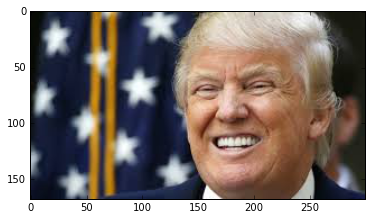

In [10]:
test_img = '../test_imgs/trump.jpg'
image = mpimg.imread(test_img)
plt.imshow(image)

Face Detection DLIB

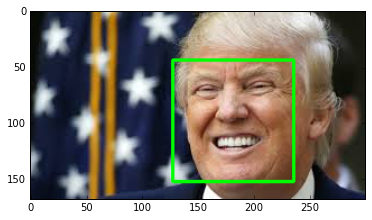

In [11]:
rects = detect_face_dlib(image)
plt.imshow(draw_rects(image, rects))

Face Feature Points & Alignment DLIB

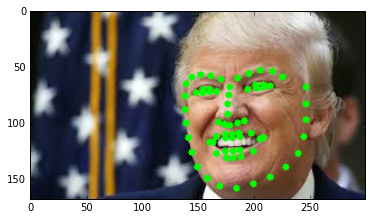

In [12]:
aligned_face, lm = align_face_dlib(image, rects[0], AlignDlib.INNER_EYES_AND_BOTTOM_LIP)
plt.imshow(draw_landmarks(image,lm))

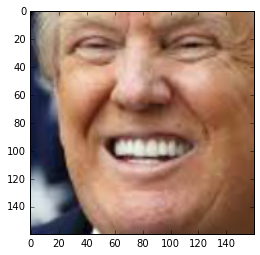

In [13]:
plt.imshow(aligned_face)

Face Detection & Feature Points MTCNN

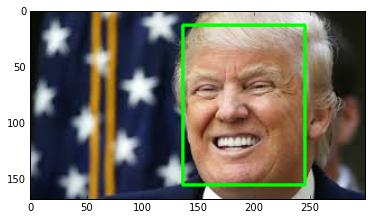

In [14]:
bbs, lm = detect_face_and_landmarks_mtcnn(image)
plt.imshow(draw_rects(image, bbs))

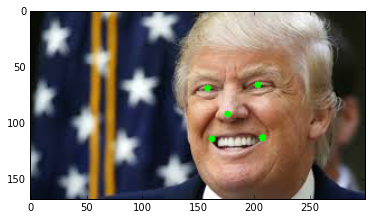

In [15]:
plt.imshow(draw_landmarks(image,lm[0]))

---> TODO

In [ ]:
aligned_face = align_face_mtcnn(image, bbs[0], lm[0])

# Process Webcam Input

Take Photo

In [20]:
camera = cv2.VideoCapture(0)
return_value,frame = camera.read()
camera.release()
img = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)

Detect Face and Show

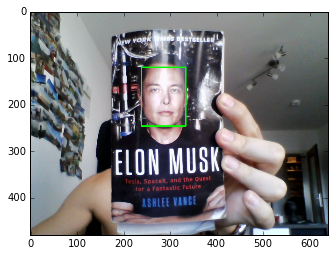

In [21]:
bbs, lm = detect_face_and_landmarks_mtcnn(img)
plt.imshow(draw_rects(img, bbs))